# LANL Earthquake prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import scipy.stats
from tqdm import tqdm_notebook
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression

import os


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
train_ori = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
# This is a index where first failure occured, used to split a validation set
sec_to_fail = 50085879
test = train_ori.iloc[:sec_to_fail, :]
train = train_ori.iloc[sec_to_fail:, :]

In [4]:
print(len(train))
print(len(test))

579059601
50085879


In [47]:
train_ori.iloc[50085879 -1, :]

acoustic_data       1.0000
time_to_failure    14.1806
Name: 50085878, dtype: float32

In [5]:
delta = 0.003
np_train = np.array(train)

In [6]:
np_test = np.array(test)

In [7]:
candi = np.where(np_train[:, 1] < delta)[0]

In [8]:
candi_t = np.where(np_test[:, 1] < delta)[0]

In [9]:
can = [candi[0]]
for i in range(1, len(candi)):
    if can[-1] == candi[i] - 1:
        can[-1] = candi[i]
    else:
        can.append(candi[i])

In [10]:
can_t = [candi_t[0]]
for i in range(1, len(candi_t)):
    if can_t[-1] == candi_t[i] - 1:
        can_t[-1] = candi_t[i]
    else:
        can_t.append(candi_t[i])

In [13]:
candi

array([ 54579189,  54579190,  54579191, ..., 571899791, 571899792,
       571899793])

In [14]:
train_segs = []
start = 0
for i in range(0, len(can)):
    train_segs.append(train.iloc[start:can[i], :])
    start = can[i] + 2

In [56]:
test_segs = []
start = 0
for i in range(0, len(can_t)):
    test_segs.append(test.iloc[start:can_t[i], :])
    start = can_t[i] + 2

In [57]:
test_segs[0]

,acoustic_data,time_to_failure
0,12,1.469100
1,6,1.469100
2,8,1.469100
3,5,1.469100
4,8,1.469100
5,8,1.469100
6,9,1.469100
7,7,1.469100
8,-5,1.469100
9,3,1.469100


In [17]:
from librosa.feature import mfcc

feat_mat = np.zeros((len(train_segs) - 1, 85))

for i in tqdm_notebook(np.arange(0,feat_mat.shape[0])):
    seg = train_segs[i]
    seg = seg.acoustic_data
    
    feat_mat[i,0] = np.mean(seg)
    feat_mat[i,1] = np.var(seg)
    feat_mat[i,2] = np.max(seg)
    feat_mat[i,3] = np.min(seg)
    # From here I added mfcc features
    mfcc_f = mfcc(y=np.array(seg, dtype=np.float32), n_mfcc=20)
    # For each of 10 mfcc features I extracted mean and variance
    for j in range(mfcc_f.shape[0]):
        feat_mat[i, 4 + 4*j] = np.mean(mfcc_f[j])
        feat_mat[i, 4 + 4*j + 1] = np.var(mfcc_f[j])
        feat_mat[i, 4 + 4*j + 2] = np.max(mfcc_f[j])
        feat_mat[i, 4 + 4*j + 3] = np.min(mfcc_f[j])
    feat_mat[i,-1] = train_segs[i + 1].time_to_failure.iloc[0]


In [94]:
test_feat_mat = np.zeros((1, 85))

seg = test_segs[1]
seg = seg.acoustic_data

test_feat_mat[0,0] = np.mean(seg)
test_feat_mat[0,1] = np.var(seg)
test_feat_mat[0,2] = np.max(seg)
test_feat_mat[0,3] = np.min(seg)
# From here I added mfcc features
mfcc_f = mfcc(y=np.array(seg, dtype=np.float32), n_mfcc=20)
# For each of 10 mfcc features I extracted mean and variance
for j in range(mfcc_f.shape[0]):
    test_feat_mat[0, 4 + 4*j] = np.mean(mfcc_f[j])
    test_feat_mat[0, 4 + 4*j + 1] = np.var(mfcc_f[j])
    test_feat_mat[0, 4 + 4*j + 2] = np.max(mfcc_f[j])
    test_feat_mat[0, 4 + 4*j + 3] = np.min(mfcc_f[j])
test_feat_mat[0,-1] = train_segs[0].time_to_failure.iloc[0]


In [95]:
test_feat_mat

array([[ 4.50781259e+00,  1.18827065e+02,  3.91400000e+03,
        -3.30100000e+03,  3.34932388e+02,  6.30965402e+02,
         7.39925475e+02,  3.00251962e+02,  2.94907947e+01,
         3.53415655e+02,  2.56169285e+02, -2.01125586e-01,
        -2.50212968e+01,  9.63106257e+01, -2.61958226e+00,
        -9.31284043e+01, -1.37620800e+01,  2.09773187e+02,
         1.36550836e+01, -8.60406631e+01, -8.23729546e+00,
         4.43224783e+01,  1.15039606e+01, -5.16086996e+01,
         7.23575567e+00,  2.37374438e+01,  3.21195711e+01,
        -2.48870901e+01,  1.26175464e+00,  2.18586695e+01,
         2.35202535e+01, -3.82528439e+01,  2.51663833e-01,
         2.25307725e+01,  1.95672513e+01, -3.30541897e+01,
        -1.85841572e+00,  1.98748127e+01,  1.62394952e+01,
        -2.96375844e+01,  2.83790954e+00,  1.54903757e+01,
         1.83271268e+01, -2.66522830e+01,  4.84848371e+00,
         1.42057759e+01,  2.83697440e+01, -2.55221747e+01,
         4.55845165e+00,  1.25047995e+01,  2.14179695e+0

In [91]:
test_feat_mat = test_feat_mat[1]

In [193]:
train.iloc[4505600]

acoustic_data      4.0000
time_to_failure    8.8567
Name: 104677356, dtype: float32

In [5]:
from librosa.feature import mfcc
from sklearn.decomposition import PCA

fs = 4000000 # Hz
window_time = 0.05 # seconds
offset = 0.002 # seconds
window_size = int(window_time*fs)

We could see an improve from the raw feature of mean/variance/min/max setting.<br>
We could further add more features

In [6]:
window_size

200000

In [7]:
from librosa.feature import mfcc

def extract_feature(dataset, length):
    feat_mat = np.zeros((length, 85))

    for i in tqdm_notebook(np.arange(0,feat_mat.shape[0])):
        start = int(i*offset*fs)
        stop = int(window_size+i*offset*fs)
        seg = dataset.iloc[start:stop,0]

        feat_mat[i,0] = np.mean(seg)
        feat_mat[i,1] = np.var(seg)
        feat_mat[i,2] = np.max(seg)
        feat_mat[i,3] = np.min(seg)
        # From here I added mfcc features
        mfcc_f = mfcc(y=np.array(seg, dtype=np.float32), n_mfcc=20)
        # For each of 10 mfcc features I extracted mean and variance
        for j in range(mfcc_f.shape[0]):
            feat_mat[i, 4 + 4*j] = np.mean(mfcc_f[j])
            feat_mat[i, 4 + 4*j + 1] = np.var(mfcc_f[j])
            feat_mat[i, 4 + 4*j + 2] = np.max(mfcc_f[j])
            feat_mat[i, 4 + 4*j + 3] = np.min(mfcc_f[j])
        feat_mat[i,-1] = dataset.iloc[stop+1,1]

    return feat_mat

In [8]:
feat_mat = extract_feature(train, 70000)

In [9]:
test_feat_mat = extract_feature(test, 6000)

In [96]:
df = pd.DataFrame(feat_mat,dtype=np.float64)
test_df = pd.DataFrame(test_feat_mat,dtype=np.float64)
dataset = df.values
test_set = test_df.values

In [122]:
def avg_res(res):
    window_size = 64
    new_res = np.zeros(res.shape,dtype=np.float64)
    for i in range(0, len(res)):
        if i < window_size:
            seg = res[i : i + window_size]
            new_res[i] = np.mean(seg)
        else:
            seg = res[i - window_size : i]
            new_res[i] = np.mean(seg)
    return new_res
    

In [25]:
def eval_result(dataset_, pred):
    res = pred(dataset_[:,:-1])
#     res = avg_res(res)
    plt.plot(res,label='predictions')
    plt.plot(dataset_[:,-1],label='actual')
    plt.legend()

    print("R^2 = ",r2_score(dataset_[:,-1],res))
    print("MAE = ",mean_absolute_error(dataset_[:,-1],res))

R^2 =  0.988431913723196
MAE =  0.27825978332776774


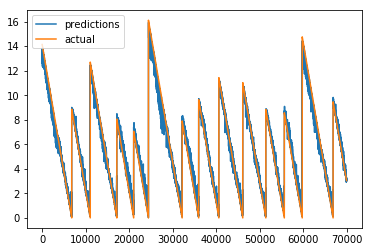

In [16]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs = 8)
rf.fit(dataset[:,:-1], dataset[:,-1])
eval_result(dataset, rf.predict)

R^2 =  0.7274133417858218
MAE =  1.5595671750069053


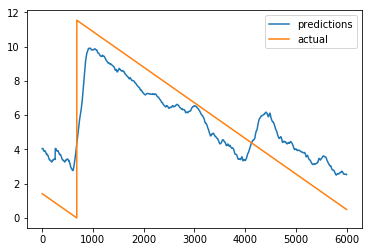

In [120]:
eval_result(test_set, rf.predict)

In [ ]:
xgr = xgb.XGBRegressor(booster='gbtree', n_estimators=1000, tree_method = 'gpu_exact', learning_rate = 2)
xgr.fit(dataset[:,:-1], dataset[:,-1])
eval_result(dataset, xgr.predict)

R^2 =  0.0
MAE =  4.017345428466797


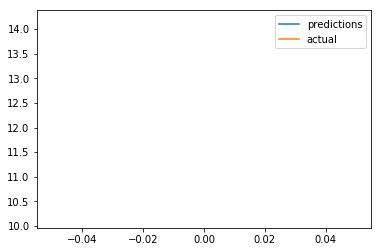

In [110]:
eval_result(test_set, xgr.predict)

## Finally I tried to ensemble two models but only got average result

In [186]:
pred_rf = rf.predict(dataset[:,:-1])
pred_xgr = xgr.predict(dataset[:,:-1])

preds = np.zeros((pred_rf.shape[0],2))

preds[:,0:1] = pred_rf.reshape(-1,1)
preds[:,1:2] = pred_xgr.reshape(-1,1)


In [187]:
ds_ens = np.concatenate((dataset[:,:-1],preds),axis=1)
ds_ens.shape

(13500, 86)

In [188]:
rf_ens = RandomForestRegressor(n_estimators = 1000, random_state = 42, n_jobs=72)

# Train the model on training data
rf_ens.fit(ds_ens, dataset[:,-1])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=72,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

R^2 =  0.5792328603044525
MAE =  1.7181738847046042


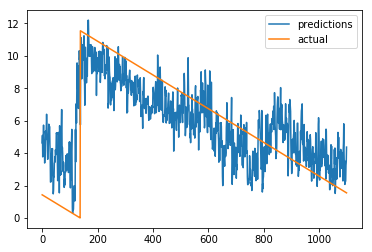

In [190]:
pred_rf = rf.predict(test_set[:,:-1])
pred_xgr = xgr.predict(test_set[:,:-1])

preds = np.zeros((pred_rf.shape[0],2))

preds[:,0:1] = pred_rf.reshape(-1,1)
preds[:,1:2] = pred_xgr.reshape(-1,1)

test_ens = np.concatenate((test_set[:,:-1],preds),axis=1)

pred_rf_ens = rf_ens.predict(test_ens)

plt.plot(pred_rf_ens,label='predictions')
plt.plot(test_set[:,-1],label='actual')
plt.legend()

print("R^2 = ",r2_score(test_set[:,-1],pred_rf_ens))
print("MAE = ",mean_absolute_error(test_set[:,-1],pred_rf_ens))

If I have more time I will try other methods like 1-conv neural network, 

In [114]:
from tqdm import tqdm_notebook

submission = pd.read_csv('sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})
X_test = pd.DataFrame(columns=df.columns, dtype=np.float64, index=submission.index)

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('./test/' + seg_id + '.csv')
    X_test.loc[seg_id, 0] = np.mean(seg.values)
    X_test.loc[seg_id, 1] = np.var(seg.values)
    X_test.loc[seg_id, 2] = np.max(seg.values)
    X_test.loc[seg_id, 3] = np.min(seg.values)
    mfcc_f = mfcc(y=np.array(seg, dtype=np.float32).flatten(), n_mfcc=20)
    # For each of 10 mfcc features I extracted mean and variance
    for j in range(mfcc_f.shape[0]):
        X_test.loc[seg_id, 4 + 4*j] = np.mean(mfcc_f[j])
        X_test.loc[seg_id, 4 + 4*j + 1] = np.var(mfcc_f[j])
        X_test.loc[seg_id, 4 + 4*j + 2] = np.max(mfcc_f[j])
        X_test.loc[seg_id, 4 + 4*j + 3] = np.min(mfcc_f[j])

In [235]:
seg = pd.read_csv('./test/seg_00030f.csv')

In [236]:
xgr.predict(X_test.values)

,acoustic_data
0,4
1,0
2,-2
3,0
4,2
5,-3
6,-9
7,-4
8,11
9,11


In [115]:
X_test.drop(columns=[84],inplace=True)

In [116]:
pred = xgr.predict(X_test.values)

submission['time_to_failure'] = pred
submission.to_csv('submission.csv')

In [244]:
submission

,time_to_failure
seg_id,
seg_00030f,4.032515
seg_0012b5,5.859446
seg_00184e,6.015700
seg_003339,8.497492
seg_0042cc,6.468748
seg_004314,2.941420
seg_004cd2,8.306857
seg_004ee5,5.004880
seg_004f1f,4.757255


### To conclude:
I used XGBoost to get current best performance on a self-constructed feature series. Including mean/var/max/min and mfcc features, further adding features might improve performance. Also data augumentation should be considered but I dont have time to implement.
For future:
    - data augumentation
    - small sliding window
    - Seq2seq prediction
    - more ensemble

In [245]:
ttf = np.array(submission)

In [251]:
for t in ttf:
    if t < delta:
        print(t)

[-0.13324684]
[-0.16951406]
